# Прогнозирование оттока клиентов из компании "ТелеДом".

## Введение:



### *Описание проекта:*
    Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.
### *Цель проекта:*
    Обучить модель для прогноза оттока клиентов на основе предоставленных данных.
### *Описание данных:*
    Таблица contract_new.csv (информация о договоре):
        - customerID — идентификатор абонента;
        - BeginDate — дата начала действия договора;
        - EndDate — дата окончания действия договора;
        - Type — тип оплаты: раз в год-два или ежемесячно;
        - PaperlessBilling — электронный расчётный лист;
        - PaymentMethod — тип платежа;
        - MonthlyCharges — расходы за месяц;
        - TotalCharges — общие расходы абонента.

    Таблица personal_new.csv (персональные данные клиента):
        - customerID — идентификатор пользователя;
        - gender — пол;
        - SeniorCitizen — является ли абонент пенсионером;
        - Partner — есть ли у абонента супруг или супруга;
        - Dependents — есть ли у абонента дети.

    Таблица internet_new.csv (информация об интернет-услугах):
        - customerID — идентификатор пользователя;
        - InternetService — тип подключения;
        - OnlineSecurity — блокировка опасных сайтов;
        - OnlineBackup — облачное хранилище файлов для резервного копирования данных;
        - DeviceProtection — антивирус;
        - TechSupport — выделенная линия технической поддержки;
        - StreamingTV — стриминговое телевидение;
        - StreamingMovies — каталог фильмов.

    Таблица phone_new.csv (информация об услугах телефонии):
        - customerID — идентификатор пользователя;
        - MultipleLines — подключение телефона к нескольким линиям одновременно.


### *План работы:*
    Шаг 1. Загрузка данных: 
        - загрузим данные 
        - выполним их первичный осмотр.
    Шаг 2. Исследовательский анализ и предобработка данных
        - выполним исследовательский анализ каждого датафрейма и при необходимости выполним предобработку
    Шаг 3. Объединение данных
        - объединим выбранные признаки в один датафрейм по ключу.
    Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
        - выполним исследовательский анализ объединённого датафрейма
        - визуализируем распределения признаков и при необходимости выполним предобработку
        - проведем корреляционный анализ.
        - сделаем выводы об имеющихся признаках: понадобятся ли они для обучения моделей.
    Шаг 5. Подготовка данных
        - выполним подготовку данных для обучения модели. 
        - разделим данные на две выборки
    Шаг 6. Обучение моделей машинного обучения
        - обучим модели
        - подберем гиперпараметры
    Шаг 7. Выбор лучшей модели
        - выберем лучшую модель
        - проверим её качество на тестовой выборке.

In [1]:
# ! pip install -q phik
# ! pip install -q category_encoders
# ! pip install --upgrade -q scikit-learn
# ! pip install -q lightgbm
# ! pip install -q catboost

In [2]:
# ИМПОРТ БИБЛИОТЕК
# Стандартные библиотеки
import os
import warnings

# База
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Анализ
from scipy.stats import shapiro, probplot
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Подготовка данных + search
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, \
OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Метрики
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

## Загрузка данных

### Загрузка

In [3]:
path_local = ['/datasets/contract_new.csv','/datasets/personal_new.csv','/datasets/internet_new.csv',\
              '/datasets/phone_new.csv']
path_server = list(map(lambda x: 'https://code.s3.yandex.net' + x, path_local))

flag = 1
for i in path_local:
    if not os.path.exists(i):
        flag = 0
        break

if flag:
    df_contract_new = pd.read_csv(path_local[0])
    df_personal_new = pd.read_csv(path_local[1])
    df_internet_new = pd.read_csv(path_local[2])
    df_phone_new = pd.read_csv(path_local[3])
else:
    df_contract_new = pd.read_csv(path_server[0])
    df_personal_new = pd.read_csv(path_server[1])
    df_internet_new = pd.read_csv(path_server[2])
    df_phone_new = pd.read_csv(path_server[3])     

### Первичный осмотр

In [4]:
dict_df = {'Таблица contract_new.csv': df_contract_new,
           'Таблица personal_new.csv': df_personal_new,
           'Таблица internet_new.csv': df_internet_new,
           'Таблица phone_new.csv': df_phone_new
          }
for key, value in dict_df.items():
    display(value.head().style.set_caption(key))
    print('\n')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950000,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.850000,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300000,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.700000,353.5


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Все заявленные признаки присутствуют, однако нет целевого признака. Нам предстоит его выделить самим. Можно привести названия столбцов к привычному стилю snake_case.

In [5]:
reg_from = '([a-z])([A-Z])'
reg_to = r'\1_\2'

for i in [df_contract_new, df_personal_new, df_internet_new, df_phone_new]:
    i.columns = [re.sub(reg_from, reg_to, i.columns[j]).lower() \
                    for j in range(len(i.columns))]

In [6]:
for i in dict_df.values():
    display(i.info(), i.describe(include='all'))
    print('\n'*2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Кажется что пустых значений нет, однако можно заметить, что тип данных у признака `total_charges` в таблице `df_contract_new` имеет тип `object`, хотя ожидалось `float`. Стоит изучить содержимое этого признака, и по видимому, содержимое остальных признаков.

### *Вывод:*
    - все признаки присутствуют
    - необходимо выделить целевой признак
    - Null значений не наблюдается
    - привели названия признаков к стилю snake_case
    - заметили неправильный тип данных у признака total_charges в таблице df_contract_new, исправим это и изучим содержимое остальных признаков

## Исследовательский анализ и предобработка данных

### Проверка данных на корректность

In [7]:
start = '\033[1m'
end = '\033[0m'
for key, value in dict_df.items():
    print(f'{start}{key}{end}')
    for i in value:
        if value[i].dtypes == 'object':
            print(f'\t- {i}: {value[i].unique()}')
    print('\n')

Таблица contract_new.csv
	- customer_id: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
	- begin_date: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 

Никаких аномальных значений в данных не найдено, но стоит отдельно изучить признак `total_charges`.

При попытке перевода данного признака в тип `float`, появилась ошибка, связанная с содержанием пробела в данных. 

In [8]:
df_contract_new[df_contract_new['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Расходы должны быть указаны, так как даты окончания договора нет, расходы за месяц есть. Заметим, что все клиенты, у которых пропуски в столбце `total_charges`, являются новыми клиентами, оплатившими абонентскую плату 2020.02.01.
Логично будет заполнить пустые значения в `total_charges` значениями из `monthly_charges`.

In [9]:
df_contract_new.loc[df_contract_new['total_charges'] == ' ', \
                    'total_charges'] = (df_contract_new
                                        .loc[df_contract_new['total_charges'] == ' ', 'monthly_charges']
                                       )

df_contract_new['total_charges'] = df_contract_new['total_charges'].astype(float)

### Проверка на дубликаты

In [10]:
print('Явные дубликаты')
for key, value in dict_df.items():
    print(f'{key}: {value.duplicated().sum()}')

Явные дубликаты
Таблица contract_new.csv: 0
Таблица personal_new.csv: 0
Таблица internet_new.csv: 0
Таблица phone_new.csv: 0


Явных дубликатов нет

In [11]:
print('Дубликаты по id')
for key, value in dict_df.items():
    print(f'{key}: {value["customer_id"].duplicated().sum()}')

Дубликаты по id
Таблица contract_new.csv: 0
Таблица personal_new.csv: 0
Таблица internet_new.csv: 0
Таблица phone_new.csv: 0


### *Вывод:*
    - заменили пробелы в признаке `total_charges` на соответствующие значения в столбце `total_changes`, так как клиенты новые
    - дубликатов не обнаружено

Дубликаты по id так же не найдены

## Объединение данных

### Объединение

Объединим все таблицы по столбцу `customer_id`.

In [12]:
df_all_info = df_contract_new.merge(df_internet_new, on='customer_id', how='left')
df_all_info = df_all_info.merge(df_personal_new, on='customer_id', how='left')
df_all_info = df_all_info.merge(df_phone_new, on='customer_id', how='left')

In [13]:
df_all_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   internet_service   5517 non-null   object 
 9   online_security    5517 non-null   object 
 10  online_backup      5517 non-null   object 
 11  device_protection  5517 non-null   object 
 12  tech_support       5517 non-null   object 
 13  streaming_tv       5517 non-null   object 
 14  streaming_movies   5517 non-null   object 
 15  gender             7043 non-null   object 
 16  senior_citizen     7043 

После объединения закономерно появились пропуски, причем связанные с подключенными услугами, скорее всего они обусловлены тем, что некоторые клиенты просто не пользуются интернет услугами или услугами телефонии.

### *Вывод:*
    - объединили все таблицы по столбцу `customer_id`
    - появилось большое количество пропусков

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Работа с пропусками

In [14]:
df_all_info[df_all_info['internet_service'].isna()].loc[:, 'internet_service':'streaming_movies']

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7030,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Заметим, если NaN и стоит в признаках, относящихся к интернет услугам, то сразу во всех. Что не мало важно, NaN стоит в признаке `internet_service`. Это значит, что данные клиенты вообще не пользуются интернетом, а не просто не подключили какие-то отдельные услуги. Попробуем заполнить данные пропуски значением `unknown`, которое будет указывать, что данных нет.
Возможно, мы позволим нашей модели найти какие то новые закономерности. Можно было бы запонить пропуски в столбцах значением No (где это возможно), но тогда можно интерпретировать это, как если бы клиент не купил услугу, но подключил интернет. Так же поступим и со столбцом `multiple_lines`.

In [15]:
df_all_info.fillna('out_of_service', inplace=True)

In [16]:
df_all_info.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
dtype: int64

На всякий случай, проверим еще раз данные на дубликаты, после объединения и заполнения пропусков

In [17]:
print('Явные дубликаты')
for key, value in dict_df.items():
    print(f'{key}: {value.duplicated().sum()}')

Явные дубликаты
Таблица contract_new.csv: 0
Таблица personal_new.csv: 0
Таблица internet_new.csv: 0
Таблица phone_new.csv: 0


Дубликатов нет

### Создание целевого признака

Выделим целевой признак из признака `end_date`. Если в `end_date` стоит `No`, значит договор еще не разорван, таких клиентов обозначим 0. Если в `end_date` стоит какая-то дата, значит договор разорван и такого клиента обозначим 1.

In [18]:
df_all_info['sub_status'] = df_all_info['end_date'].apply(lambda x: 1 if x != 'No' else 0)

После создания целевого признака, на основе `end_date`, произойдет утечка целевого признака, через все абсолютные даты, поэтому есть смысл удалить признаки `end_date` и `begin_date`

### Создание новых входных признаков

Создадим признак `remaining_days_payment`, который будет отражать количество оставшихся дней по договору

Для начала переведем признак `begin_date` к типу datetime

In [19]:
df_all_info['begin_date'] = pd.to_datetime(df_all_info['begin_date'])

Создадим новый признак

In [20]:
# Функции, которые рассчитывают количество оставшихся дней по договору, 
# в зависимости от типа оплаты и даты заключения договора    
date = pd.to_datetime('2020-02-01')

def count_days(x, new_date, date, n, m):
    if new_date >= date:
        days = n + abs((date - new_date).days)
    else:
        days = m - abs((date - new_date).days)
        
    return days

def remaining_days(x):
    new_date = x['begin_date'].replace(year=2020)
    
    if x['type'] == 'One year':
        days = count_days(x, new_date, date, 0, 365)
            
    elif x['type'] == 'Two year':
        if x['begin_date'].year % 2 == 0:
            days = count_days(x, new_date, date, 0, 730)
        else:
            days = count_days(x, new_date, date, 365, 365)
    else:
        days = 30
    return days


In [21]:
df_all_info['remaining_days_payment'] = df_all_info.apply(remaining_days, axis=1)

Добавим признак, который будет отражать количество дней пройденных по контракту

In [22]:
df_all_info.loc[df_all_info['end_date'] == 'No', 'end_date'] = date
df_all_info['end_date'] = pd.to_datetime(df_all_info['end_date'])
df_all_info['days_passed'] = (df_all_info['end_date'] - df_all_info['begin_date']).apply(lambda x: x.days)

In [23]:
df_all_info[['begin_date', 'end_date', 'type', 'remaining_days_payment', 'days_passed']].head(20)

,begin_date,end_date,type,remaining_days_payment,days_passed
0,2020-01-01,2020-02-01,Month-to-month,30,31
1,2017-04-01,2020-02-01,One year,60,1036
2,2019-10-01,2020-02-01,Month-to-month,30,123
3,2016-05-01,2020-02-01,One year,90,1371
4,2019-09-01,2020-02-01,Month-to-month,30,153
5,2019-03-01,2020-02-01,Month-to-month,30,337
6,2018-04-01,2020-02-01,Month-to-month,30,671
7,2019-04-01,2020-02-01,Month-to-month,30,306
8,2017-07-01,2020-02-01,Month-to-month,30,945
9,2014-12-01,2017-05-01,One year,304,882


Удалим признаки `end_date` и `begin_date` во избежании утечки.

In [24]:
df_all_info = df_all_info.drop(['end_date', 'begin_date'], axis=1)

### Исследовательский анализ

Вспомогательные функции

In [25]:
def control_of_analysis_graphs(df, df_2, column, xlabel, title, \
                               range_size_hist=(0, 0), bins=25, \
                               hist=True, shapiro=True, label=['НЕ разорвали договор', 'Разорвали договор']):
        
    # строим графики
    if hist:
        plt.figure(figsize=(15, 5));
        plt.suptitle(title, fontweight='bold', fontsize=16)
        hist_print(df, df_2, range_size_hist, xlabel, bins, column, label)
        qqplot_print(df, df_2, column, xlabel, label)
    boxplot_print(df, df_2, column, label)
    
    # Проводим тест Шапиро-Уилка
    if shapiro:
        shapiro_test(df, df_2, column)

Построение гистограммы

In [26]:
def hist_print(df, df_2, range_size, xlabel, bins, column, label):
    sns.kdeplot(df[column], label=label[0])
    sns.kdeplot(df_2[column], label=label[1])
    plt.legend()
    plt.grid()
    plt.title('Распределение значений')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('Плотность распределения', fontsize=13)
    plt.show()

Тест Шапиро-Уилка

In [27]:
def shapiro_test(df, df_2, column):
    shapiro_result = shapiro(df[column])
    shapiro_result_2 = shapiro(df_2[column])
    if shapiro_result[1] >= 0.05:
        print(f'Распределение значений клиентов,',
              f'НЕ разорвавших договор, нормальное, p-значение = {shapiro_result[1]}')
    else:
        print(f'Распределение значений клиентов,',
              f'НЕ разорвавших договор, не является нормальным, p-значение = {shapiro_result[1]}' )
    if shapiro_result_2[1] >= 0.05:
        print(f'Распределение значений клиентов,',
              f'разорвавших договор, нормальное, p-значение = {shapiro_result_2[1]}')
    else:
        print(f'Распределение значений клиентов,',
              f'разорвавших договор, не является нормальным, p-значение = {shapiro_result_2[1]}' )

Построение боксплота

In [28]:
def boxplot_print(df, df_2, column, label):
    plt.figure(figsize=(15, 5));
    ax = plt.subplot()
    ax.boxplot([df[column], df_2[column]])
    ax.set_xticklabels(label)
    plt.title('График разброса')
    plt.grid()
    plt.show()

Построение Q-Q plot

In [29]:
def qqplot_print(df, df_2, column, ylabel, label):
    plt.figure(figsize=(15, 5));
    plt.subplot(1, 2, 1)
    probplot(df[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[0])
    plt.xlabel('Теоретические квантили')
    
    plt.subplot(1, 2, 2)
    probplot(df_2[column], plot=plt);
    plt.ylabel(ylabel)
    plt.title(label[1])
    plt.xlabel('Теоретические квантили')
    plt.show()

Построение круговых диаграмм

In [30]:
def pie_print(df, columns, title):
    wp = { 'linewidth' : 2, 'edgecolor' : "white" }
    pivot = df.pivot_table(index='sub_status', columns=columns, values='customer_id', aggfunc='count')
    axes = pivot.plot(kind='pie', autopct='%1.0f%%', ylabel='', \
                      wedgeprops = wp, subplots=True, figsize=(12,5), legend=False, title=title)
    for i in range(len(pivot.columns)):
        axes[i].set_title(pivot.columns[i])
    plt.show()

#### Тип оплаты

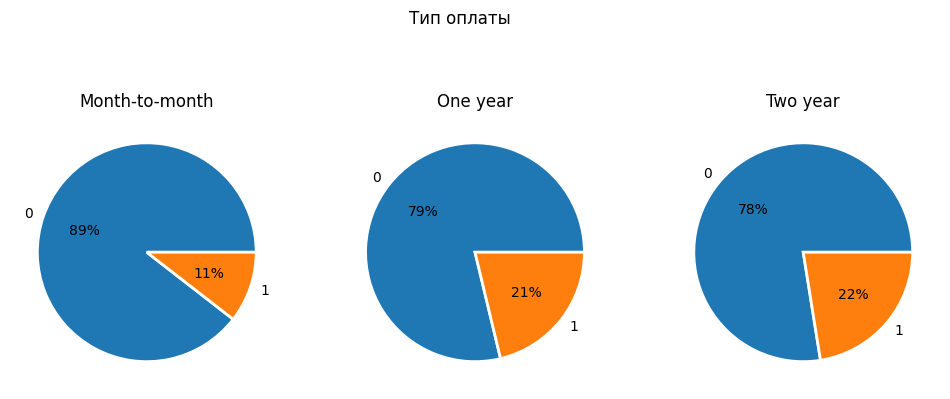

In [31]:
pie_print(df_all_info, 'type', 'Тип оплаты')

Примерно одинаковый процент разорвавших договор клиентов среди тех, кто заключал договор на 1 год или на 2 года. Скорее всего это связано с тем, что клиенты не готовы продолжительное время терпеть до окончания договора и решают его прервать, в отличии от клиентом с помесячным договором.

#### Электронный рассчетный лист

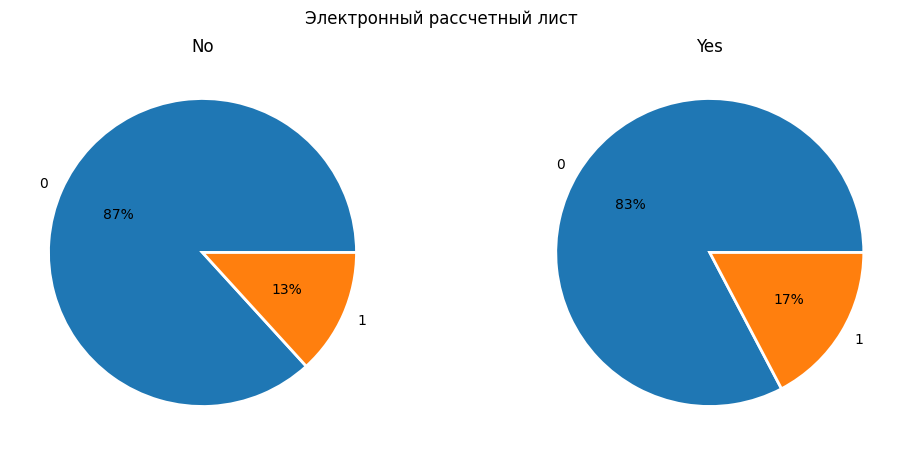

In [32]:
pie_print(df_all_info, 'paperless_billing', 'Электронный рассчетный лист')

Больший процент разорвавших договор клиентов среди тех у кого был электронный рассчетный лист.

Клиенты имеющие электронный рассчетный лист с большей вероятностью разрывали договор.

#### Тип платежа

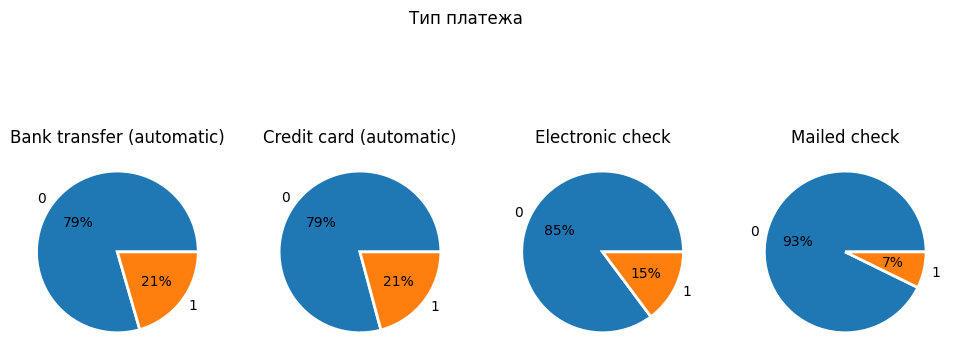

In [33]:
pie_print(df_all_info, 'payment_method', 'Тип платежа')

Наибольший процент разорвавших договор клиентов среди тех, кто пользовался bank transfer или credit card. Важно обратить внимание на то, что данная оплата судя по всему происходила автоматически, и возможно, многие продления происходили случайно у тех клиентов, кто забыл снять автоматическое продление.

#### Расходы за месяц

In [34]:
RANDOM_STATE = 22072024

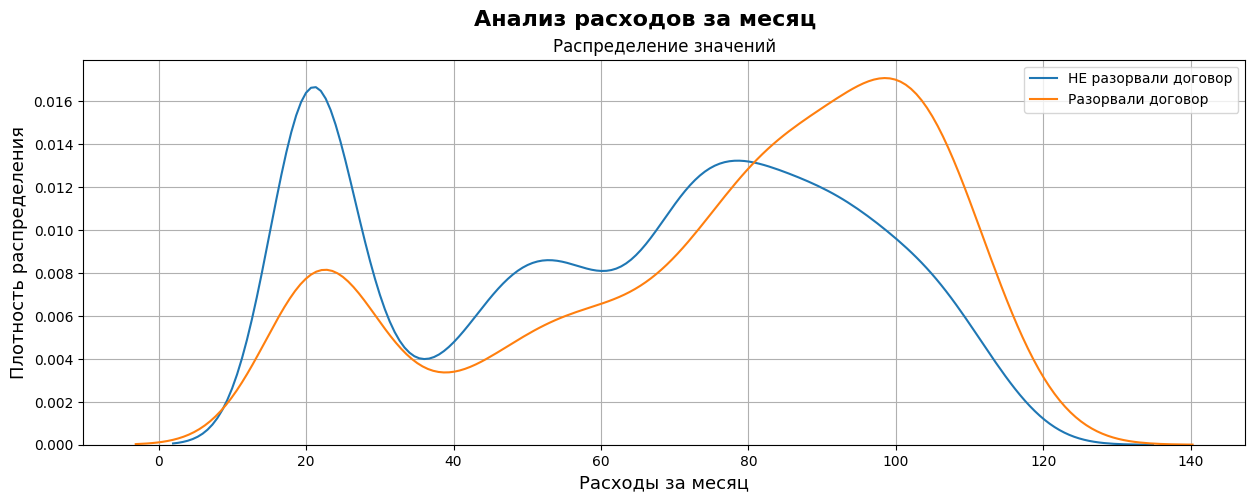

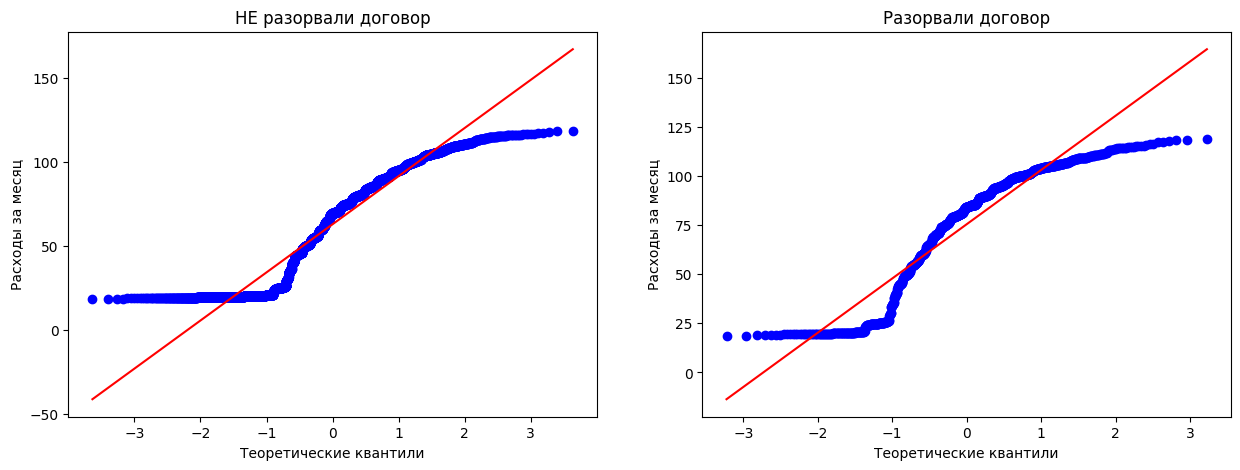

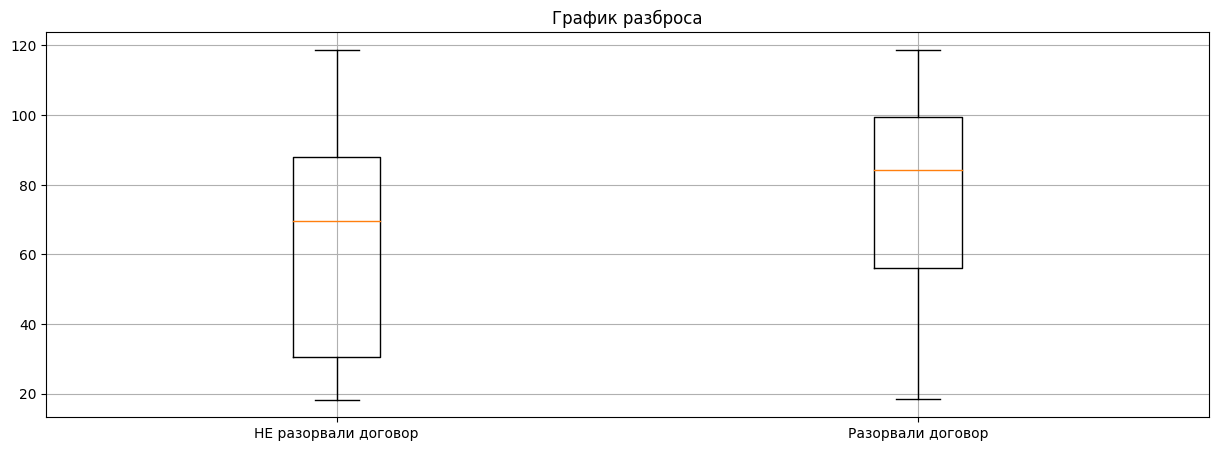

Распределение значений клиентов, НЕ разорвавших договор, не является нормальным, p-значение = 4.203895392974451e-45
Распределение значений клиентов, разорвавших договор, не является нормальным, p-значение = 1.7239521244411066e-26


In [35]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'monthly_charges', \
                           'Расходы за месяц', 'Анализ расходов за месяц')

Отметим, что разорвавшие договор клиенты платили в месяц в среднем больше, чем НЕ разорвавшие договор клиенты. Около 70 в среднем у НЕ разорвавших и около 85 у разорвавших, причем пик у разорвавших приходится на отметку 100.

Оба распределения являются ненормальными судя по графикам и тесту Шапиро-Уилка.

Воспользуемся PowerTransformer на этапе подготовки данных, для приведения распределений к нормальному виду.

#### Общие расходы абонента

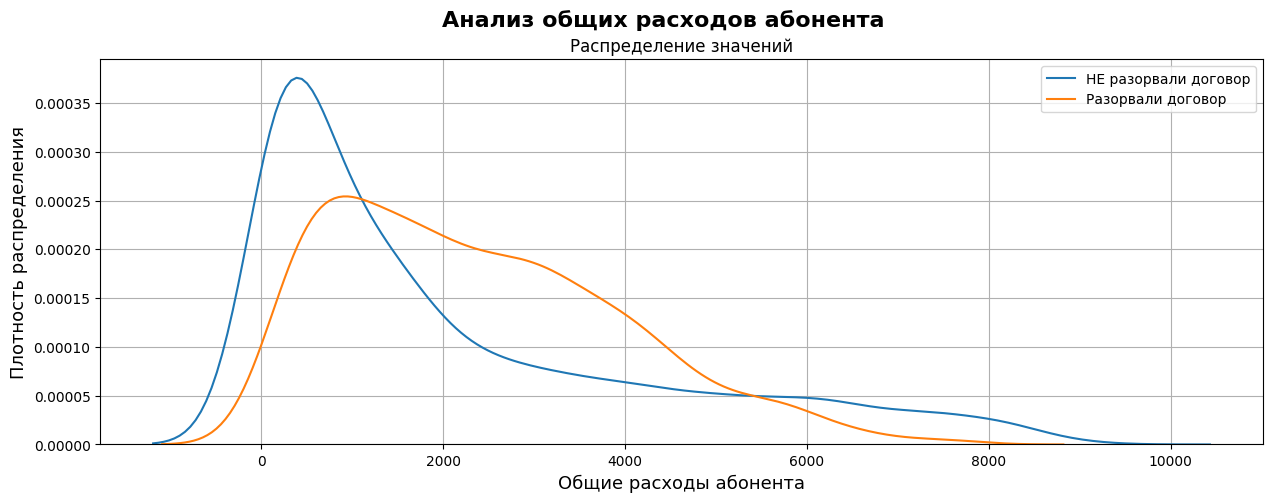

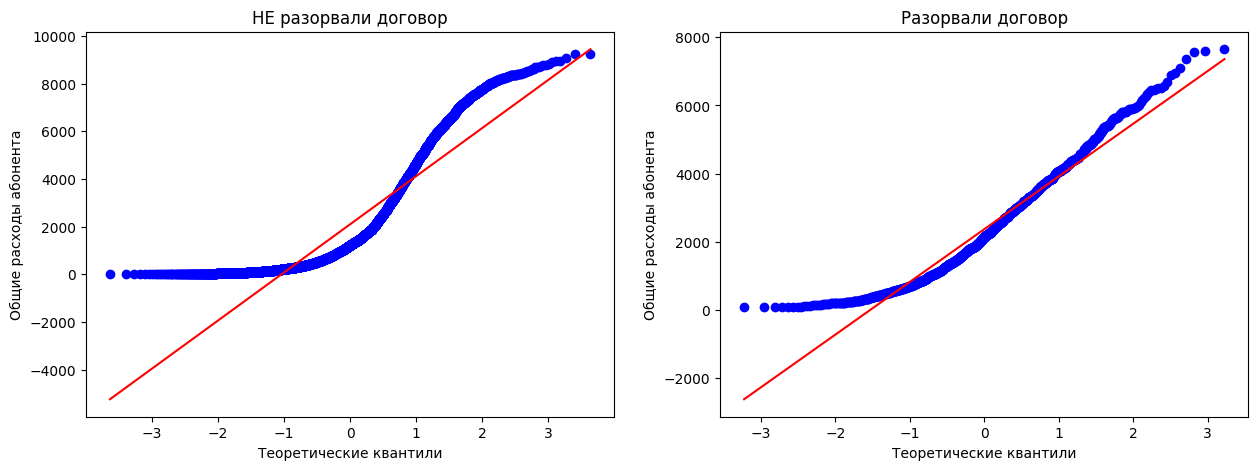

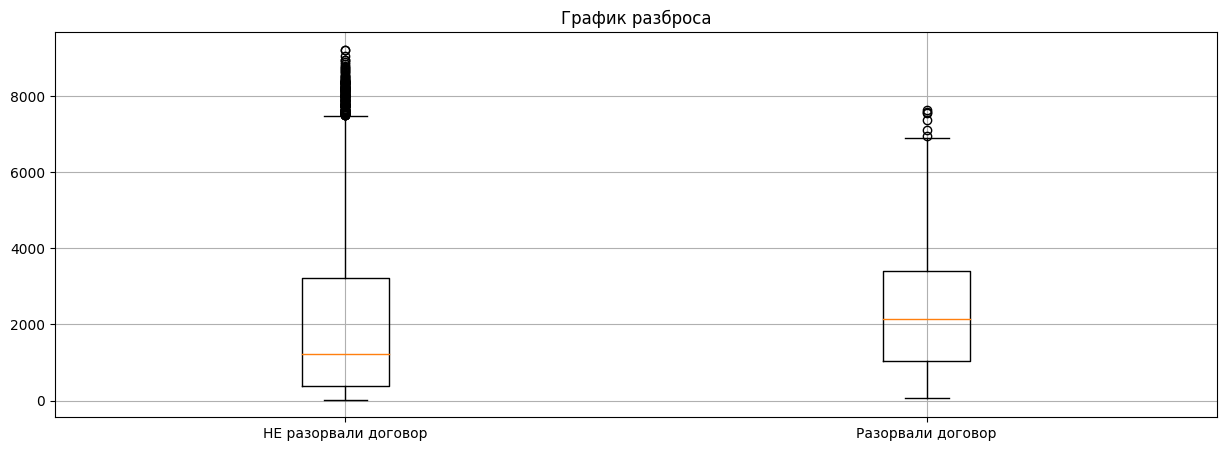

Распределение значений клиентов, НЕ разорвавших договор, не является нормальным, p-значение = 0.0
Распределение значений клиентов, разорвавших договор, не является нормальным, p-значение = 1.0826285647676989e-18


In [36]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'total_charges', \
                           'Общие расходы абонента', \
                           'Анализ общих расходов абонента')

Общие расходы разорвавших договор клиентов так же больше, чем у тех кто договор не разорвал.

Распределения так же являются ненормальными

#### Пол клиента

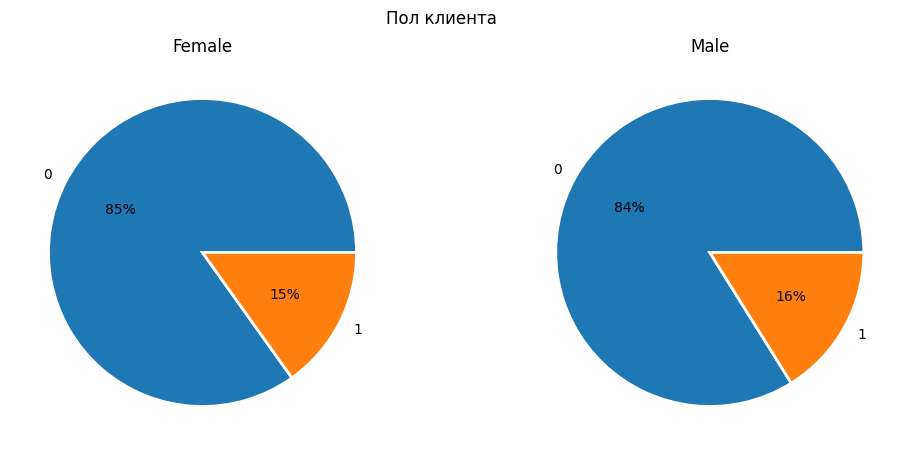

In [37]:
pie_print(df_all_info, 'gender', 'Пол клиента')

Судя по круговым диаграммам разрыв договора не особо зависит от пола клиента. Так как и мужчины и женщины разрывают договор примерно с равным процентом от общего количества.

#### Является ли клиент пенсионером

Преобразуем значения данного признака по аналогии с другими категориальными признаками к виду Yes/No

In [38]:
df_all_info['senior_citizen'] = df_all_info['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

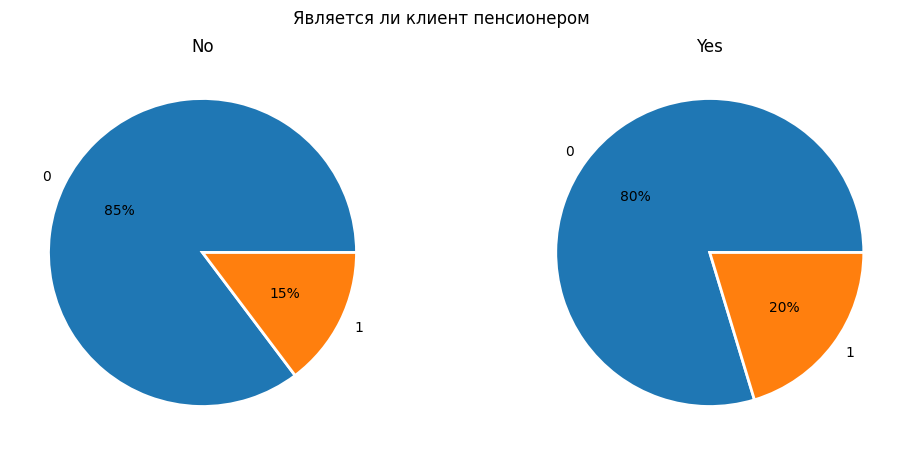

In [39]:
pie_print(df_all_info, 'senior_citizen', 'Является ли клиент пенсионером')

20% среди всех пенсионеров разрывают договор, и 15% среди всех НЕ пенсионеров разрывают договор. Значит разорвавший договор клиент с немного большей вероятностью будет пенсионером.

#### Есть ли супруг или супруга

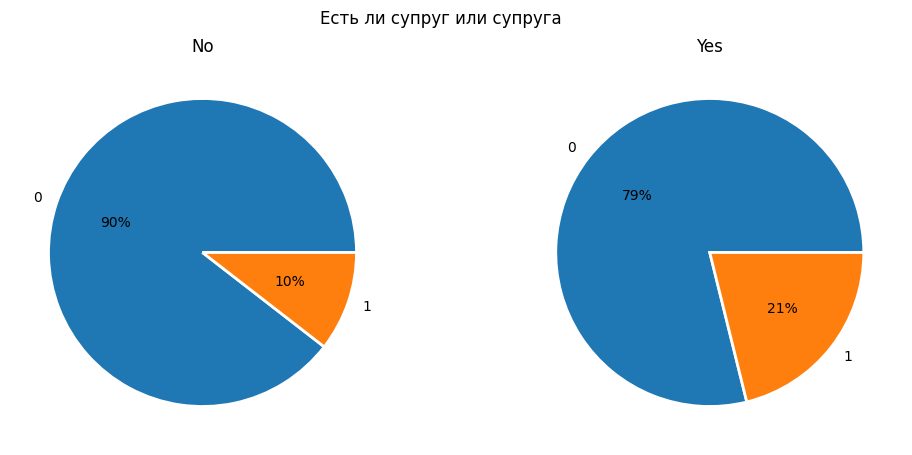

In [40]:
pie_print(df_all_info, 'partner', 'Есть ли супруг или супруга')

Примечательно, что клиенты с супругом или супругой с большей долей разрывают договор, чем клиенты без второй половинки.

#### Есть ли дети

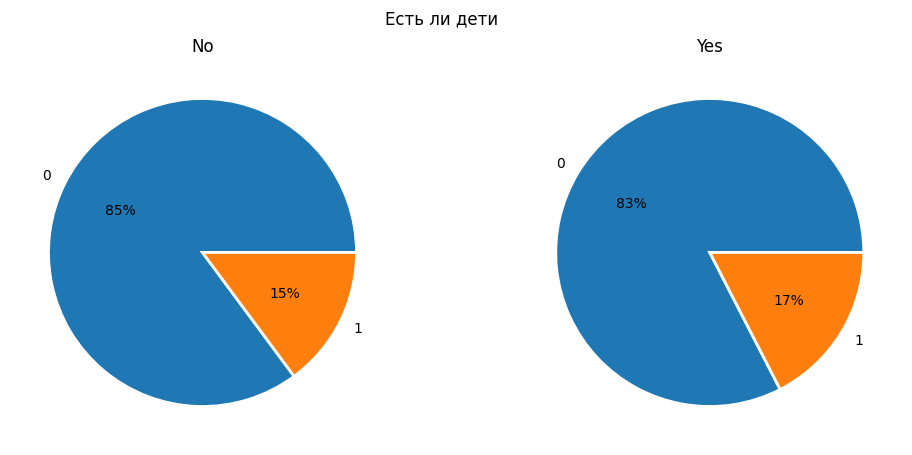

In [41]:
pie_print(df_all_info, 'dependents', 'Есть ли дети')

Немного больше процент разорвавших договор у тех, кто имеет детей.

#### Тип подключения интернета

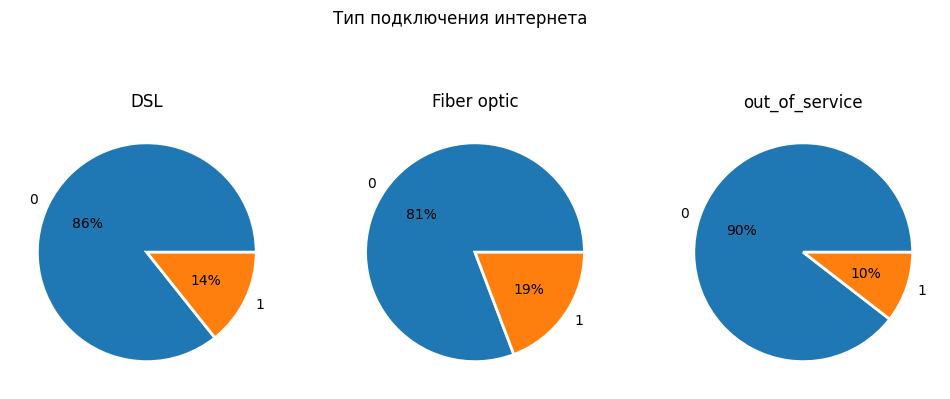

In [42]:
pie_print(df_all_info, 'internet_service', 'Тип подключения интернета')

Интересно, что среди тех, кто пользуется оптоволоконным кабелем процент разорвавших договор больше всего. И самый маленький процент среди тех, кто интернет услугами вообще не пользуется.

#### Есть ли блокировка опасных сайтов

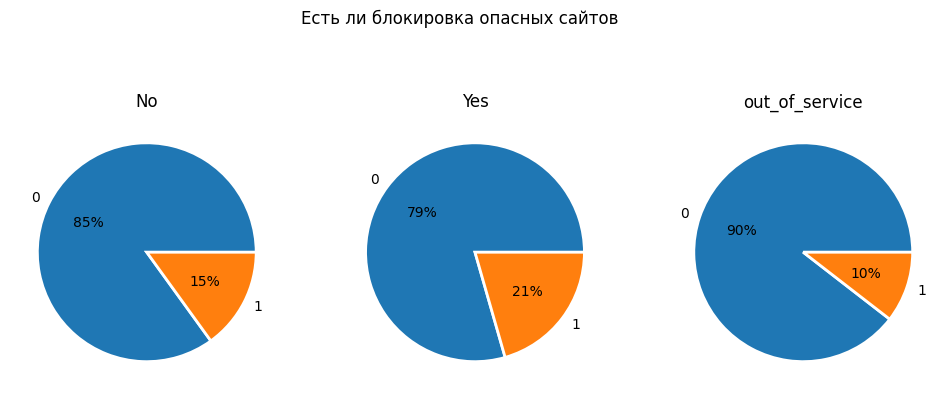

In [43]:
pie_print(df_all_info, 'online_security', 'Есть ли блокировка опасных сайтов')

И снова мы видим такую ситуацию. Больше разорвавших договор среди тех, кто пользуется услугой блокировки опасных сайтов.

#### Есть ли облачное хранилище

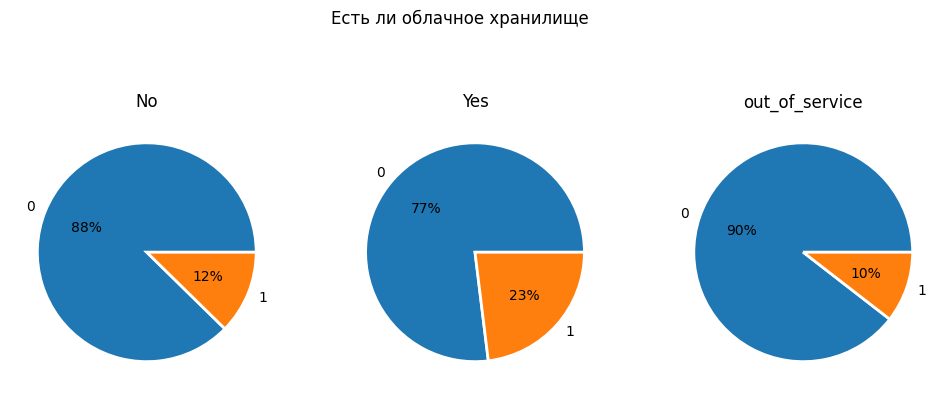

In [44]:
pie_print(df_all_info, 'online_backup', 'Есть ли облачное хранилище')

#### Есть ли антивирус

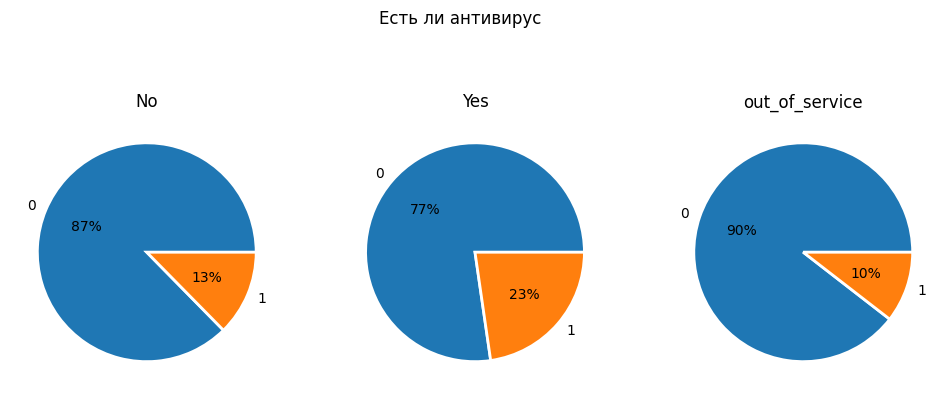

In [45]:
pie_print(df_all_info, 'device_protection', 'Есть ли антивирус')

#### Есть ли выделенная линия тех. поддержки

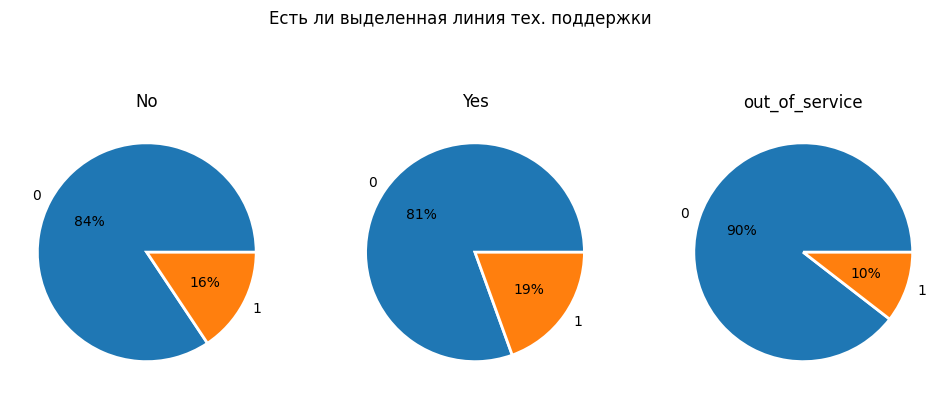

In [46]:
pie_print(df_all_info, 'tech_support', 'Есть ли выделенная линия тех. поддержки')

#### Есть ли стриминговое телевидение

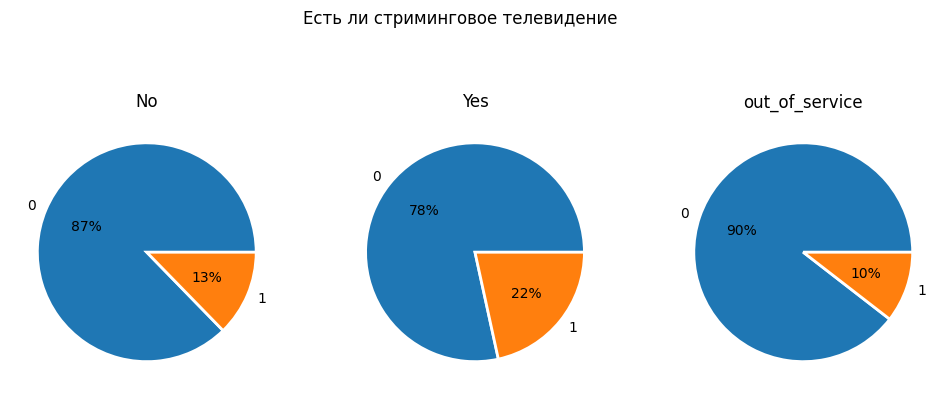

In [47]:
pie_print(df_all_info, 'streaming_tv', 'Есть ли стриминговое телевидение')

#### Есть ли каталог фильмов

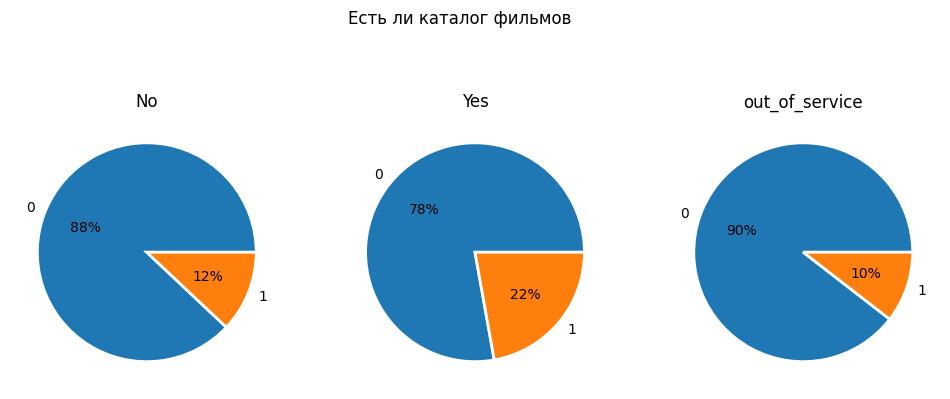

In [48]:
pie_print(df_all_info, 'streaming_movies', 'Есть ли каталог фильмов')

#### Есть ли подключение телефона к нескольким линиям

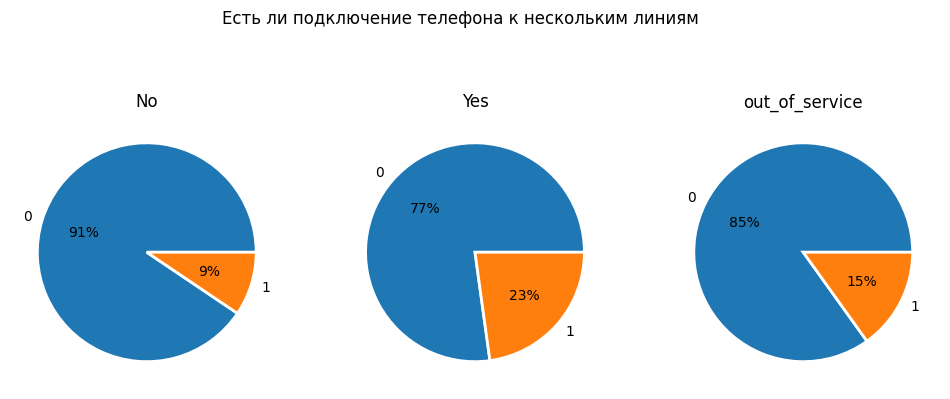

In [49]:
pie_print(df_all_info, 'multiple_lines', 'Есть ли подключение телефона к нескольким линиям')

**Примерно одна и та же ситуация со всеми доп. услугами. Среди тех, кто этими услугами пользуется, больше клиентов, которые договор разрывают.
Возможно это связано с их не высоким качеством и, в следствии, неудовлетворенностью ими, но за дополнительную плату. Мы видели, что клиенты разорвавшие договор в среднем платили больше. Это подтверждают круговые диаграммы.**

#### Количество оставшихся дней по договору

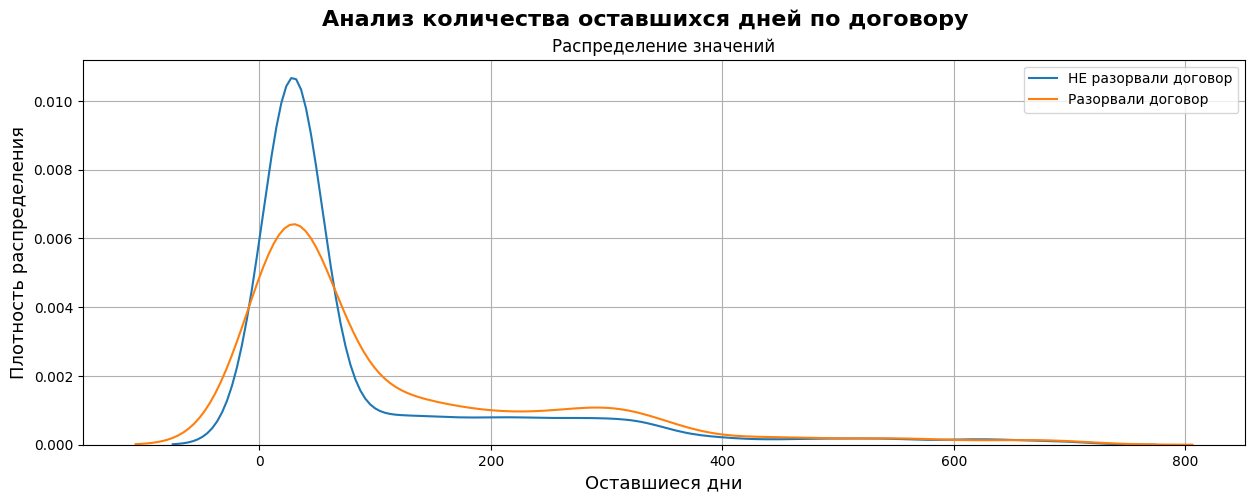

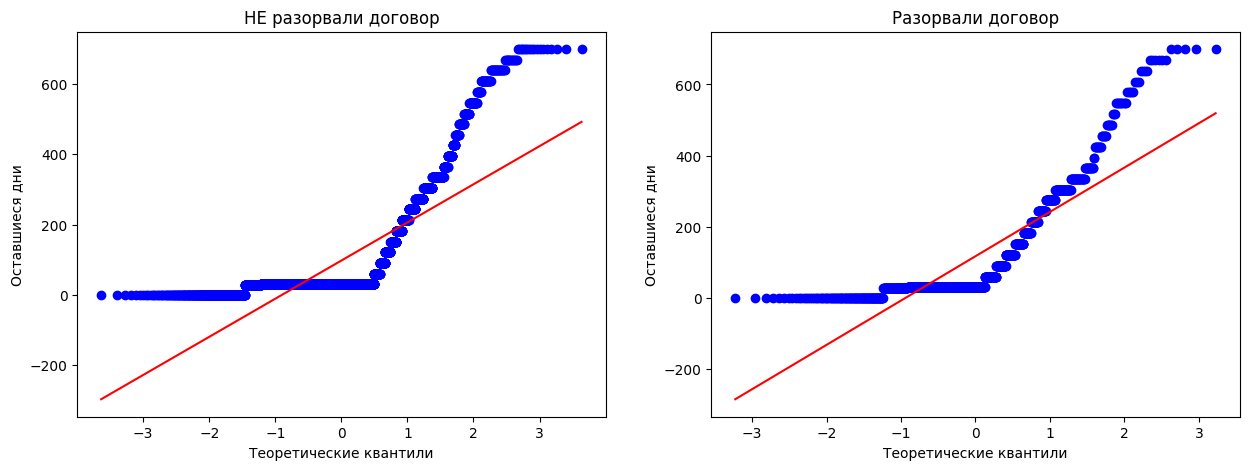

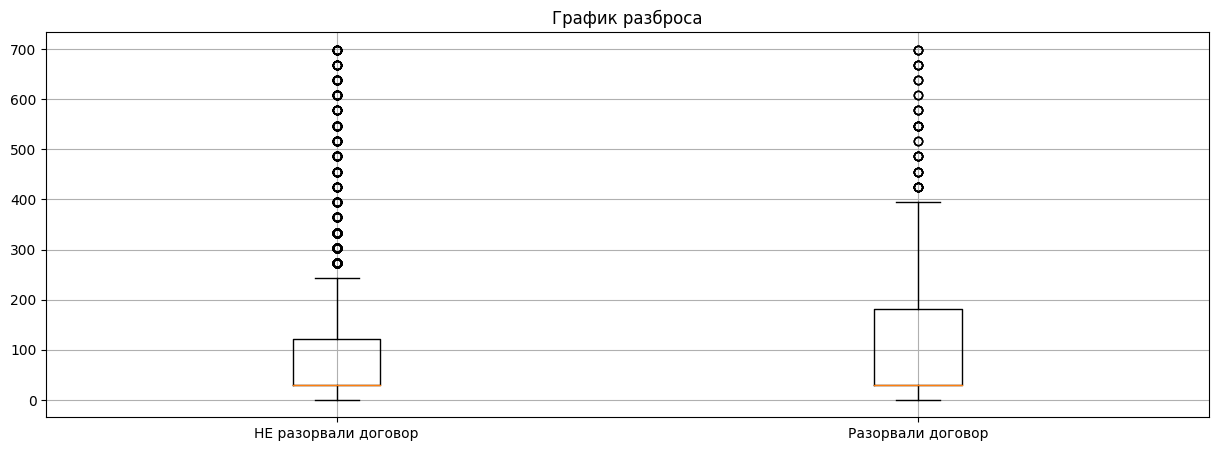

Распределение значений клиентов, НЕ разорвавших договор, не является нормальным, p-значение = 0.0
Распределение значений клиентов, разорвавших договор, не является нормальным, p-значение = 1.7044717692888806e-38


In [50]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'remaining_days_payment', \
                           'Оставшиеся дни', \
                           'Анализ количества оставшихся дней по договору')

Присутствует некоторое количество выбросов, убирать их не будем.
Распределение не является нормальным.

#### Количество дней, пройденных с момента заключения договора

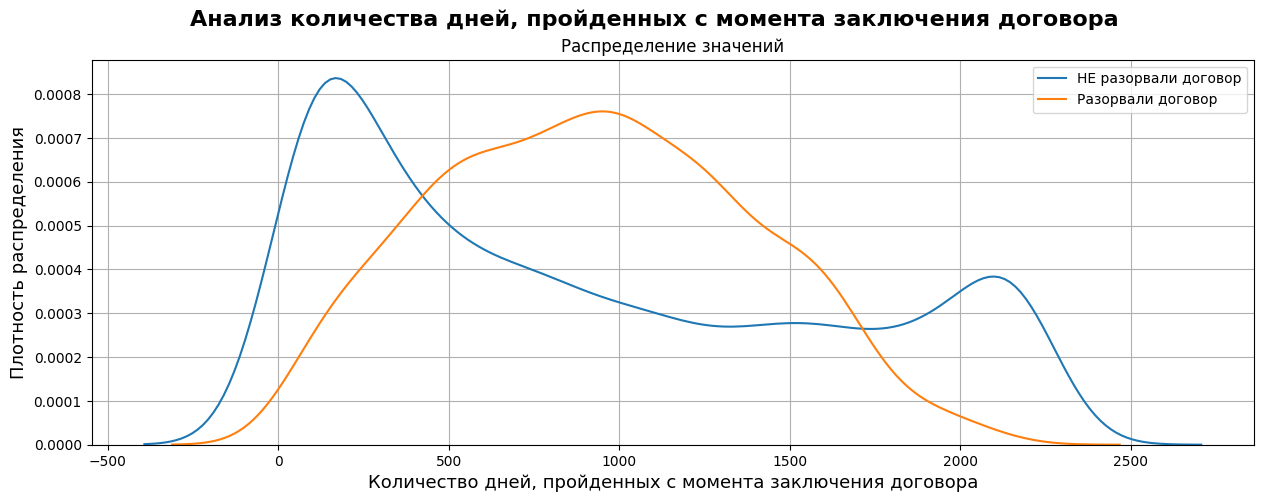

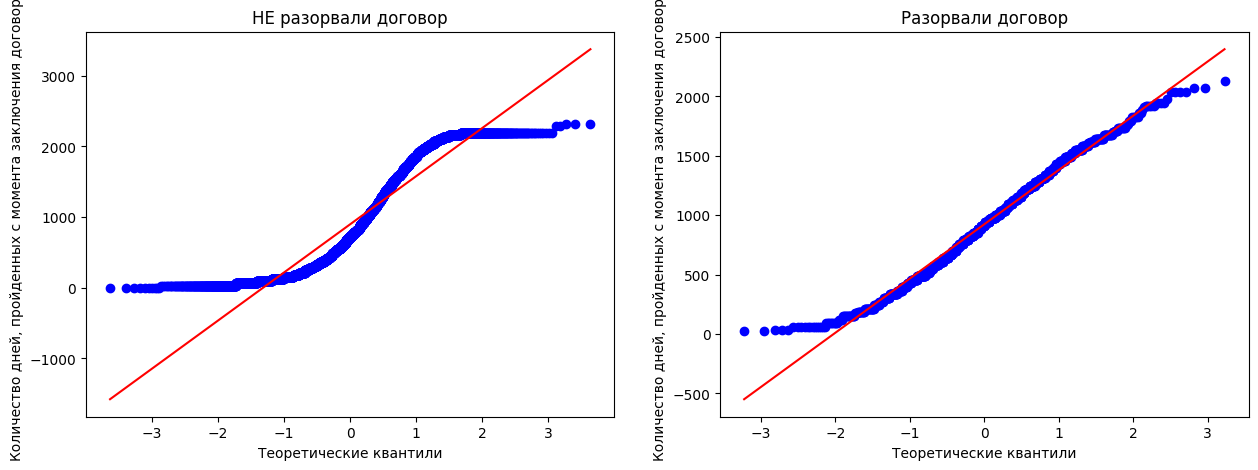

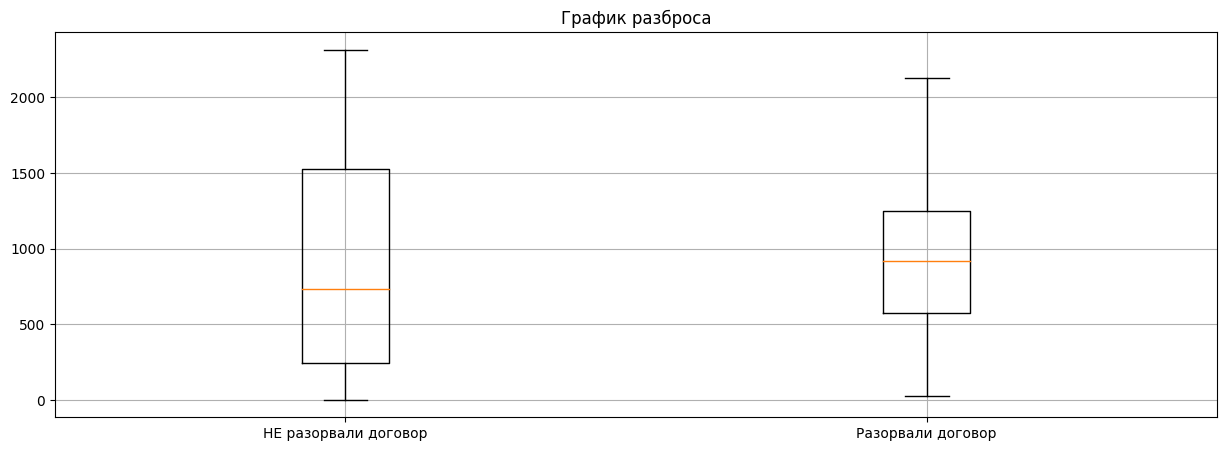

Распределение значений клиентов, НЕ разорвавших договор, не является нормальным, p-значение = 0.0
Распределение значений клиентов, разорвавших договор, не является нормальным, p-значение = 7.419177272538491e-09


In [51]:
control_of_analysis_graphs(df_all_info[df_all_info['sub_status'] == 0].sample(5000, random_state=RANDOM_STATE), \
                           df_all_info[df_all_info['sub_status'] == 1], 'days_passed', \
                           'Количество дней, пройденных с момента заключения договора', \
                           'Анализ количества дней, пройденных с момента заключения договора')

Количество дней, пройденных с момента заключения договора в среднем немного больше у клиентов, разорвавших договор.

### Корреляционный анализ

Установим `customer_id` в качестве индексов. 

In [52]:
df_all_info = df_all_info.set_index('customer_id')

Проведем корреляционный анализ.

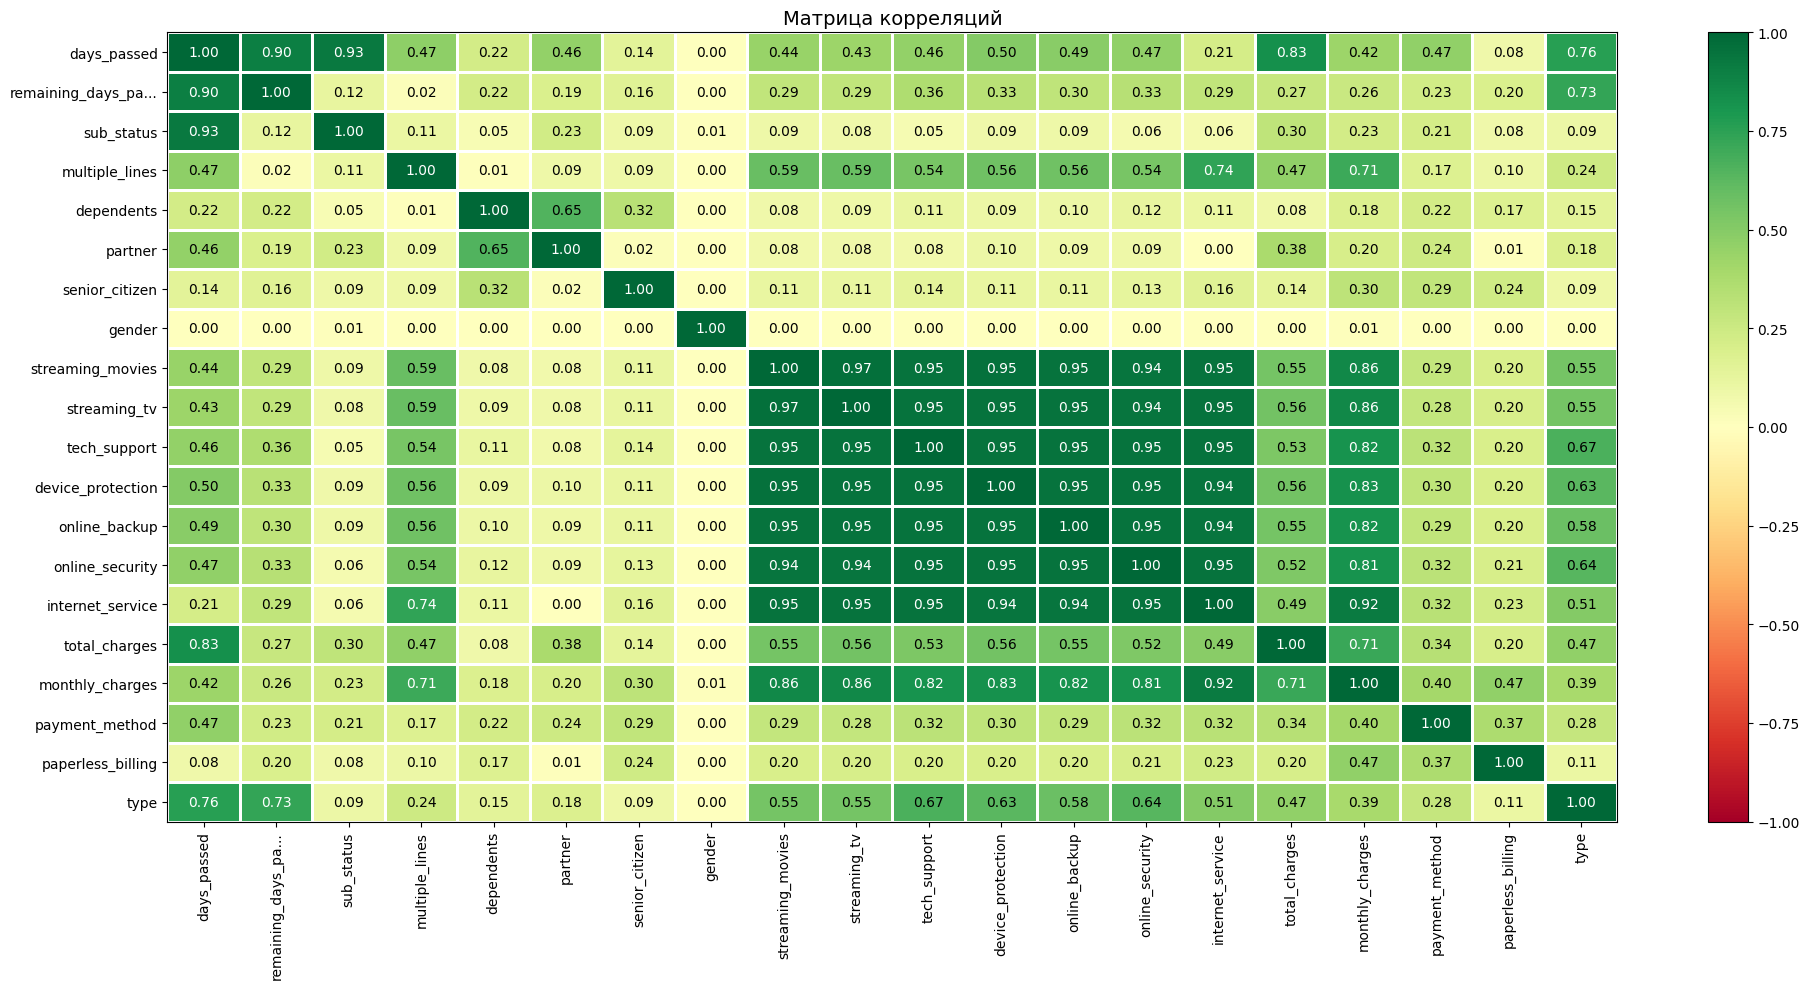

In [53]:
corr_matrix = phik_matrix(df_all_info, \
                          interval_cols=['remaining_days_payment', 'total_charges', 'monthly_charges', 'days_end'])

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, \
                        y_labels=corr_matrix.index, title='Матрица корреляций', figsize=(20, 10))

Так же замечена мультиколлиниарность среди признаков `streaming_tv`, `streaming_movies`, `tech_support`, `device_protection`, `online_backup`, `online_security` и `internet_service`.

Удалим сильно коррелирующие между собой признаки. Оставим только тот, который лучше всего коррелирует с целевой переменной. Это признак `streaming_movies`

In [54]:
df_all_info = df_all_info.drop(['gender', 'device_protection', 'online_backup', 'internet_service', 'streaming_tv', \
                                'tech_support', 'online_security'], axis=1)

### *Вывод:*
    - заполнили пропуски в признаках значениями out_of_service, связанных с интернет услугами и телефонией
    - создали целевой признак sub_status на основе столбца end_date.
    - создали новые входные признаки, один из которых будет отражать количество оставшихся дней по договору, а другой то, сколько дней по договору уже пройдено.
    - удалили признаки end_date и begin_date во избежании утечки
    - провели исследовательский анализ каждого признака
    - провели корреляционный анализ по результатом которого удалили признаки streaming_tv, tech_support, device_protection, online_backup, online_security и internet_service, так как между ними была мультиколлинеарность, а на качество модели они почти не влияли. Удалили признак gender, так как он не коррелирует с другими признаками
    
**Предварительный портрет клиента, который с наибольшей вероятностью расторгнет договор:**

    - тип оплаты: 1 или 2 года
    - тип платежа: bank transfer или credit card
    - расходы за месяц: около 85
    - есть супруг или супруга
    - активно пользовался интернет услугами или услугами телефонии

## Подготовка данных

Разбиваем данные на тестовую и тренировочную выборки с перемешиванием и стратификацией по целевому признаку, что бы избежать дисбаланс классов.

In [55]:
warnings.filterwarnings('ignore')
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(df_all_info.drop('sub_status', axis=1), 
                                                    df_all_info['sub_status'], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=df_all_info['sub_status'])

Отбираем столбцы с количественными и категориальными признаками. Строим пайплайны для подготовки данных.

In [56]:
num_col = X_train.select_dtypes(include=['number']).columns.tolist()
cat_col = X_train.select_dtypes(include=['object']).columns.tolist()
print(f'num_col: {num_col},\n\ncat_col: {cat_col}')

num_col: ['monthly_charges', 'total_charges', 'remaining_days_payment', 'days_passed'],

cat_col: ['type', 'paperless_billing', 'payment_method', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines']


In [57]:
num_pipe = Pipeline(
    [
        ('transformer', PowerTransformer()),
        ('scale', StandardScaler())
    ]
)

cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='out_of_service')),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

Используем ColumnTransformer

In [58]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col),
        ('cat', cat_pipe, cat_col)
    ], 
    remainder='passthrough'
)

Создаем финальный пайплайн

In [59]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE))
    ])

Прописываем модели для перебора.

In [60]:
param_grid_logistic = [
     {
        'model': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', \
                                     solver='liblinear')],
         'model__solver': ['liblinear', 'newton-cg'],
         'model__max_iter': [100, 200, 500],
         'preprocessor__num__scale': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


param_grid_tree = [
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'model__max_depth': range(5, 15),
        'model__max_features': range(10,20),
        'preprocessor__num__scale': ['passthrough'],
        'preprocessor__cat__encoder': [OrdinalEncoder(), 'passthrough']
    }
]

param_grid_catboost = [
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'model__iterations': [50, 100, 200, 300, 400, 500],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'preprocessor__num__scale': ['passthrough'],
        'preprocessor__cat__encoder': [TargetEncoder(), 'passthrough']
    }
    
]

Будем отдельно прогонять модели через GridSearchCV

### *Вывод:*
    - разбили данные на тренировочную и тестовую выборки в отношении 1 к 3 с перемешиванием и стратификацией по целевому признаку
    - прописали все необходимые пайплайны для подготовки данных и обучения моделей

## Обучение моделей

### Логистическая регрессия

In [61]:
search_log = GridSearchCV(pipe_final, param_grid_logistic, cv=5, scoring='roc_auc', n_jobs=-1)
search_log.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression(class_weight='balanced',
                                                       random_state=22072024,
                                                       solver='liblinear')],
                          'model__max_iter': [100, 200, 500],
                          'model__solver': ['liblinear', 'newton-cg'],
                          'preprocessor__num__scale': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       'passthrough']}],
             scoring='roc_auc')

Параметры лучшей модели

In [62]:
search_log.best_params_ 

{'model': LogisticRegression(class_weight='balanced', random_state=22072024,
                    solver='liblinear'),
 'model__max_iter': 100,
 'model__solver': 'newton-cg',
 'preprocessor__num__scale': StandardScaler()}

Результат ROC-AUC на кросс-валидации по тренировочной выборке:

In [63]:
best_log = search_log.best_score_
best_log

0.7329549469235268

### Дерево решений

In [64]:
search_tree = GridSearchCV(pipe_final, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
search_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                                                          'multiple_lines'])])),
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [DecisionTreeClassifier(class_weight='balanced',
                                                           random_state=22072024)],
                          'model__max_depth': range(5, 15),
                          'model__max_features': range(10, 20),
                          'preprocessor__cat__encoder': [OrdinalEncoder(),
                                                         'passthrough'],
                          'preprocessor__num__scale': ['passthrough']}],
             scoring='roc_auc')

Параметры лучшей модели

In [65]:
search_tree.best_params_ 

{'model': DecisionTreeClassifier(class_weight='balanced', random_state=22072024),
 'model__max_depth': 7,
 'model__max_features': 12,
 'preprocessor__cat__encoder': OrdinalEncoder(),
 'preprocessor__num__scale': 'passthrough'}

Результат ROC-AUC на кросс-валидации по тренировочной выборке:

In [66]:
best_tree = search_tree.best_score_
best_tree

0.8003355364694184

### Бустинг

In [67]:
search_catboost = GridSearchCV(pipe_final, param_grid_catboost, cv=5, scoring='roc_auc', n_jobs=-1)
search_catboost.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'remaining_days_payment',
                                                                          'days_passed']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer_cat',
                                                                                          SimpleImputer(fill_value='out_of_...
                                       ('model',
                                        LogisticRegression(random_state=22072024))]),
             n_jobs=-1,
             param_grid=[{'model': [<catboost.core.CatBoostClassifier object at 0x7f0bd1309ac0>],
                          'model__iterations': [50, 100, 200, 300, 400, 500],
                          'model__learning_rate': [0.01, 0.1, 0.2],
                          'preprocessor__cat__encoder': [TargetEncoder(),
                                                         'passthrough'],
                          'preprocessor__num__scale': ['passthrough']}],
             scoring='roc_auc')

Параметры лучшей модели

In [68]:
search_catboost.best_params_ 

{'model': <catboost.core.CatBoostClassifier at 0x7f0bd1309ac0>,
 'model__iterations': 500,
 'model__learning_rate': 0.2,
 'preprocessor__cat__encoder': TargetEncoder(),
 'preprocessor__num__scale': 'passthrough'}

Результат ROC-AUC на кросс-валидации по тренировочной выборке:

In [69]:
best_catboost = search_catboost.best_score_
best_catboost

0.9301134174885082

### *Вывод:*
Провели перебор гиперпараметров и моделей с помощью GridSearchCV. Используем такие модели, как:

    - LogisticRegression()
    - DecisionTreeClassifier()
    - CatBoostClassifier()


## Выбор лучшей модели

### Лучшая модель

Выведем на экран показатели лучших моделей

In [70]:
results = pd.DataFrame({'roc-auc (train)': [best_log, best_tree, best_catboost],
                       'accuracy': [accuracy_score(y_test, search_log.predict(X_test)),\
                                   accuracy_score(y_test, search_tree.predict(X_test)),\
                                   accuracy_score(y_test, search_catboost.predict(X_test))]},
                       ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'])

In [71]:
results.sort_values('roc-auc (train)', ascending=False)

,roc-auc (train),accuracy
CatBoostClassifier,0.930113,0.934696
DecisionTreeClassifier,0.800336,0.709824
LogisticRegression,0.732955,0.695060


Очевидно, что лучше всего с задачей справляется модель **CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024)**

У данной модели показатель ROC-AUC на кросс-валидации по тренировочной выборке лучше.

Результат лучшей модели на тестовой выборке.

In [72]:
roc_auc_score(y_test, search_catboost.predict_proba(X_test)[:,-1])

0.9184289734491617

Результат удовлетворяет необходимому значению roc-auc>=0.85

### Кривая roc-auc и матрица ошибок

Построим ROC- кривую

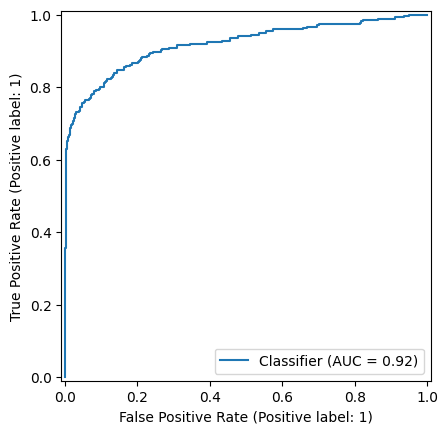

In [73]:
RocCurveDisplay.from_predictions(y_test, search_catboost.predict_proba(X_test)[:, 1]);

Создадим матрицу ошибок

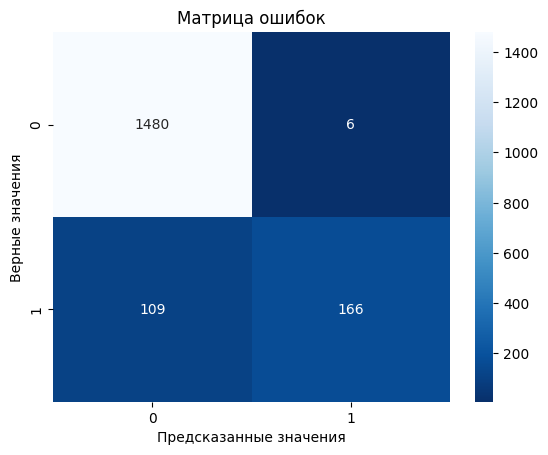

In [74]:
sns.heatmap(confusion_matrix(y_test, search_catboost.predict(X_test)), annot=True, fmt='d', cmap='Blues_r');
plt.title('Матрица ошибок')
plt.ylabel('Верные значения')
plt.xlabel('Предсказанные значения');

Судя по ROC-кривой и по матрице ошибок, показатели False Negative и False Positive низкие. Помним, что данные показатели были особенно важны заказчику, значит наша модель более чем справляется с поставленной задачей.

### Оценка важности признаков

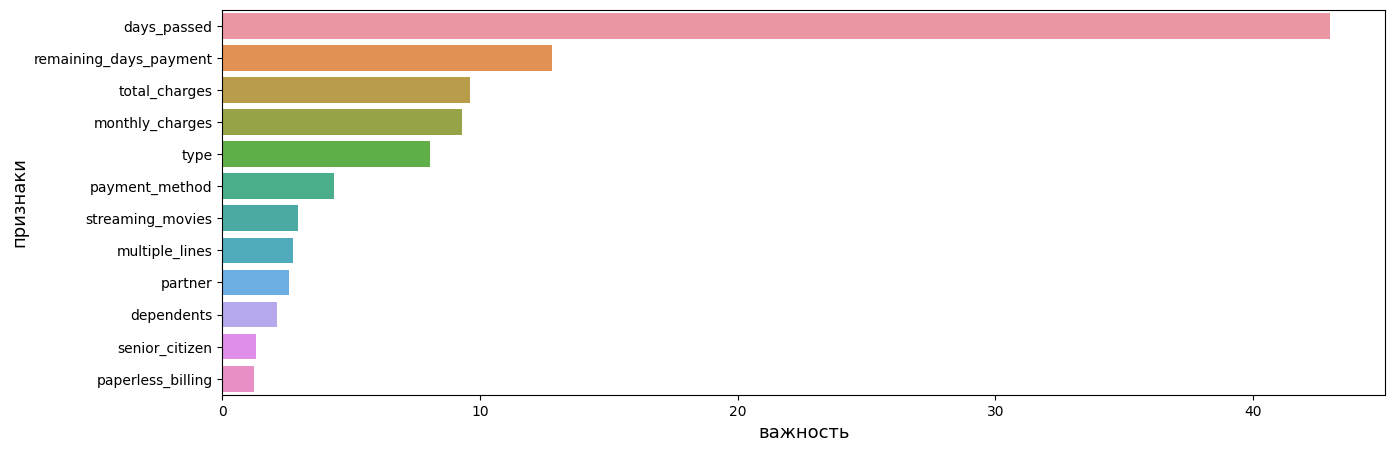

In [75]:
table_importance = (pd.DataFrame(search_catboost.best_estimator_[-1].feature_importances_, num_col + cat_col)
                    .sort_values(by=0, ascending=False)
                    .reset_index()
                   )

plt.figure(figsize=(15, 5));
sns.barplot(x=table_importance[0], y=table_importance['index']);
plt.xlabel('важность', fontsize=13);
plt.ylabel('признаки', fontsize=13);

Самым важным признаком оказался `days_passed`.

Наимение важными: `paperless_billing` и `senior_citizen`.

### *Вывод:*
    - выбрали лучшую модель: CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024). Ее показатели roc-auc на тестовой выборке: 0.918
    - построили ROC-кривую и матрицу ошибок. Убедились в том, что ошибки False Positive и False Negative не значительны
    - проанализировали важность признаков.

## Итоговый вывод:

    Главная задача:

        Обучить модель для прогноза оттока клиентов на основе предоставленных данных.
        
    Этапы работы:
        Шаг 1. Загрузка данных: 
            - выгрузили данные
            - провели их первичный осмотр
            - привели названия столбцов к стилю snake_case.
        Шаг 2. Исследовательский анализ и предобработка данных
            - проверили данные на корректность
            - проверили данные надубликаты
            - заменили пробелы в признаке `total_charges` на соответствующие значения в столбце `total_changes`, так как клиенты новые
        Шаг 3. Объединение данных
            - объединили все таблицы по cusomer_id.
        Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
            - заполнили пропуски в признаках значениями out_of_service, связанных с интернет услугами и телефонией
            - создали целевой признак sub_status на основе столбца end_date
            - создали новые входные признаки, один из которых будет отражать количество оставшихся дней по договору, а другой то, сколько дней по договору уже пройдено
            - удалили признаки end_date и begin_date во избежании утечки
            - провели исследовательский анализ каждого признака
            - провели корреляционный анализ по результатом которого удалили признак gender, так как он не коррелирует с другими признаками, а так же удалили streaming_tv, tech_support, device_protection, online_backup, online_security и internet_service, так как между ними была мультиколлинеарность, а на качество модели они почти не влияли
        Шаг 5. Подготовка данных
            - разбили данные на тренировочную и тестовую выборки в отношении 1 к 3 с перемешиванием и стратификацией по целевому признаку
            - прописали все необходимые пайплайны для подготовик данных и обучения моделей
        Шаг 6. Обучение моделей машинного обучения
            - с помощью GridSearchCV обучили такие модели, как:
                * LogisticRegression()
                * DecisionTreeClassifier()
                * СatBoostClassifier()
        Шаг 7. Выбор лучшей модели
            - сравнив лучшие модели каждого вида по трем показателям: roc-auc на тренировочной выборке, roc-auc на тестовой выборке и accuracy, сделали вывод, что лучше всего с задачей справляется модель CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024). Ее показатель roc-auc на тестовой выборке: 0.9184289734491617
            - построили ROC-кривую и матрицу ошибок. Убедились в том, что ошибки False Positive и False Negative не значительны
            - проанализировали важность признаков.

**Лучшая модель: CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=22072024)**

### Рекомендации бизнесу:

Во время проведения исследовательского анализа данных были замечены интересные закономерности:
 - клиенты, имеющие тип оплаты One year или Two year с большей вероятностью разрывают договор (22-21% клиентов)
 - клиенты, которые используют в качестве оплаты Bank Transfer или Credit Card так же чаще разрывают договор (21% клиентов)
 - клиенты, которые активно пользуются дополнительными услугами (интернет услугами или телефонией) с большей вероятностью разрывают договор
 - разорвавшие договор клиенты платили в месяц в среднем больше, чем НЕ разорвавшие договор клиенты. Около 70 в среднем у НЕ разорвавших и около 85 у разорвавших, причем пик у разорвавших приходится на отметке 100.
 - клиенты с супругом или супругой с большей долей разрывают договор, чем клиенты без второй половинки. (21% клиентов)
     
Поэтому были разработы рекомендации бизнесу:
- разработать специальные предложения для клиентов с типом оплаты на 1 или 2 года, чтобы продлить их контракты. Например, скидки при продлении договора или бесплатные месяцы обслуживания.
- предлагайте промокоды и скидки клиентам, которые используют банк или кредитную карту для платежей, чтобы стимулировать их продолжить пользоваться услугами.
- введите программу лояльности для клиентов, которые активно пользуются интернет-услугами или телефонией. Предлагайте бонусы за долгосрочное использование.
- разработайте программы вознаграждений для клиентов с высокими ежемесячными расходами (около 85). Это могут быть скидки, бесплатные услуги или эксклюзивные предложения.
- разработайте семейные тарифы и пакеты услуг для клиентов, которые имеют супругу или супруга. Например пониженная месячная оплата.
- введите пакеты, которые включают интернет и телефонию по более выгодным ценам для удержания клиентов, которые активно пользуются этими услугами.
- улучшите качество клиентского обслуживания, особенно для клиентов, которые могут быть склонны к расторжению договора. Быстрое и эффективное решение проблем клиентов может снизить их желание уйти.
